# NequIP Tutorial

Simon Batzner, Albert Musaelian, Lixin Sun   
Contact: batzner@g.harvard.edu

This is an introduction to the NequIP code. It will cover: 

- how to work with equivariant networks both in general and in e3nn
- how to build a NequIP model 
- how to load a dataset 
- how to train a model 
- I/O in NequIP
- how to predict with a trained model

In particular, we will build a model that predicts potential energy and obtains forces via backprop as the negative gradient of the energy. 

### Requirements

To run this tutorial, you will need the same requirements as the general NequIP code, outlined in the README.md. We assume you have read the NequIP paper (https://arxiv.org/abs/2101.03164) and have some understanding of what an equivariant network is (we recommend https://arxiv.org/abs/1802.08219 and https://arxiv.org/abs/1807.02547 as introductions). 

## Equivariant Networks and the ```Irreps``` class

Before we can dive into how NequIP works, we need to understand a little bit about how to translate the theory of equivariant networks into code. In particular, we need to understand the `e3nn` code (https://e3nn.org/) that NequIP uses under the hood to build equivariant networks. 

The key parameters for building different networks are irreducible representations (https://en.wikipedia.org/wiki/Irreducible_representation) used inside the network, a term from group representation theory, which itself is a way to describe group theory in the language of linear algebra. The fundamental class that describes the irreducible representations is the ```Irrep``` class (singular) in ```e3nn```, representing the irreducible representations of $O(3)$ and describing how features in NequIP behave under rotations and mirrors. 



The ```Irreps``` class (plural) combines different ```Irrep``` objects, in particular it constitutes a direct sum of representations. For example, a direct sum of $D_1$, $D_2$, and $D_3$ can be written this like this: 


$$
D_1 \oplus D_2 \oplus D_3 = \begin{bmatrix} D_1 & 0 & 0 \\ 0 & D_2 &  0  \\ 0 & 0 & D_3\end{bmatrix}
$$

This is the fundamental class we work with to build different networks. It is therefore worth our time to understand a bit better what it contains. A typical set of irreps in NequIP or e3nn has the following form:

Irreps: ```mxlp```, where 

* ```m``` is the multiplicity, i.e. the number of features
* ```x``` simply stands for times 
* ```l``` is the rotation order (describing whether our internal features are scalars, vectors, ...) 
* ```p``` describes the parity, where we have two choices: even or odd, ```e``` or ```o```, which describes how the tensor transforms under mirrors. An example of building a set of 16 vectors with odd parity would thus be:  ```16x1o```


For our purposes, we use the irreps to describe all features inside our network, the most important of which are: 

a) the set of hidden, internal features inside the network, given by ```feature_irreps_hidden```. Here are a few examples: 

* an invariant, SchNet-type network with only scalar interactions and 32 features: ```32x0e```
* an equivariant network with l = {0, 1} and without parity as used in the NequIP paper: ```32x0e + 32x1e```
* an equivariant network with l = {0, 1, 2} and with parity: ```32x0o + 32x0e + 32x1o + 32x1e + 32x2o + 32x2e```

b) the irreps for the spherical harmonics expansion of the edges, given by ```irreps_edge_sh```, i.e. how the interatomic vectors transform under symmetry. These are given simply as ```Irreps``` with multiplicity $1$ and increasing $l$. If you want to include parity-equivariance, you have to make sure to alternate the parity of the irreps since $(-1)^l$ gives alternative even/odd behavior. If you are not interested in using parity-equivariance, just use even parities: 

* parity-equivariant irreps up to l=2: ```1x0e + 1x1o + 1x2e```
* irreps without parity equivariance up to l=2: ```1x0e + 1x1e + 1x2e```

c) the output of the network. For example, predicting an even scalar (such as a potential energy), would be an Irrep of ```1x0e```, a vector would be ```1x1o``` (vectors have odd parity). 


### Side note on parity and pseudoscalars/-vectors/-tensors

In addition to scalars, vectors, tensors, the ```Irreps``` also include a description on parity, i.e. the behavior under mirrors. Parity is best explained via the example of a vector and a pseudovector. As an example of a vector, we will choose a force acting on atom (top image below), as an example of a pseudovector, we will choose the magnitic field $\vec{B}$ (bottom image below, image source: https://en.wikipedia.org/wiki/Pseudovector). In both visualizions, the structure is mirrored from the left (source) to the right (target). 

The *vectors* in the top image transform as we would expect, i.e. they flip sign in the x dimension. 

In contrast, the B-field in the bottom image constitutes a *pseudo-vector*, that means it gains an additional sign under an inversion. If we were to just mirror the B-field lines, we would get the wrong answer. 

Mathematically, this is rooted in the cross product. To show this, let $R$ be a matrix representation of an improper rotation, i.e. a composition of a mirror and (potentially) a rotation, acting on vector $x \in X$ such that $x' = Rx$. We know that improper rotations have $det(R) = -1$. 

We also know that for $R$, the following always holds for the cross product $\times$: 

$$
R(x_a)R(x_b) = det(R)R(x_a \times x_b)
$$

Therefore if we let $R$ act on $x_a$, $x_b$, we get for the cross product under an improper rotation: 

$$
x_c' = x_a' \times x_b' = (Rx_a) \times (Rx_b) = det(R)R(x_a \times x_b) = det(R)x_c
$$

and since $det(R) = -1$, we see that under the cross product, $x_c'$ picks up an additional sign. Therefore, we can say that a cross product of two vectors gives a pseudo-vector. 

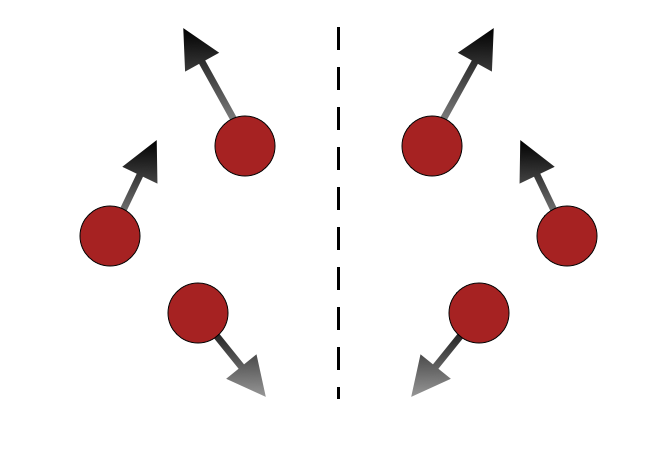

In [48]:
from IPython.display import Image
Image(filename="parity.png", width = 600, height = 300)

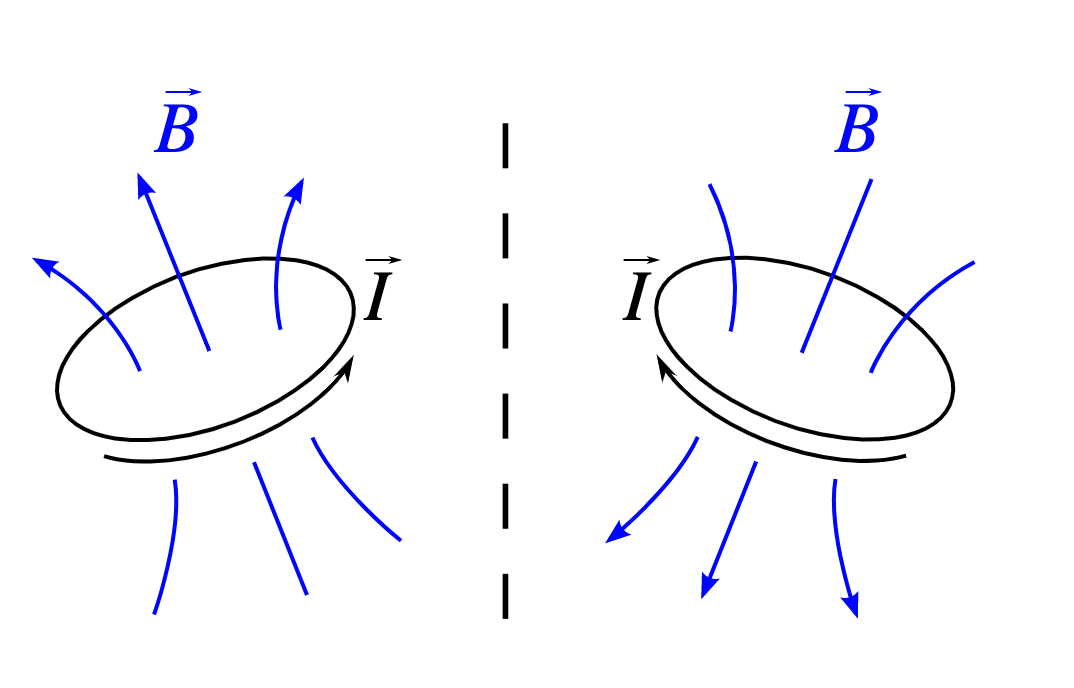

In [49]:
Image(filename="pv.png", width = 650, height = 300)

### Design choices

Now is also a good time to discuss how to choose the irreps. In general, we have found that going from $l=0 \rightarrow l=1$ gives a massive improvement. Going from $l=1 \rightarrow l=2$ further improves performance significantly. Going from $l=2 \rightarrow l=3$ further improves it, but after that we start to see a diminishing return on investment (our primary investment here is memory).  

We also find that adding parity can significantly boost prediction. To design a network without parity, we would choose the ```e``` parity for all states (hidden features and spherical harmonics). To design networks *with* parity, we alternate the irreps on the spherical harmonics, for example ```1x0e + 1x1o + 1x2e```, and to construct all possible paths, we use both ```e``` and ```o``` irreps in the hidden features, for example ```32x0o + 32x0e + 32x1o + 32x1o + 32x2o + 32x2e```

However, adding higher order ```l```s and parity increases the memory footprint of the model as well as inference time. It therefore represents a tradeoff between accuracy and efficiency. For many systems, we found going up to $l_{max}=2$ with parity (as described above) a good choice, and a feature representation of 16 or 32 to be enough. If you can afford it, we were able to achieve our best results with $l_{max} = 3$, parity and a feature dimension of 32. To construct an equivariant network all you need is a $l_{max} = 1$ network. This is a key hyperparameter you will need to optimize.

Let's try to translate some of this into code. We can build Irreps using the ```o3.Irreps``` class in e3nn: 

First, let's just create a different ```Irrep``` for different geometric quantities, in particular we will build: 

* a scalar: $l=0$, $p=e$
* a pseudoscalar: $l=0$, $p=o$ (https://en.wikipedia.org/wiki/Pseudoscalar)
* a vector: $l=1$, $p=o$
* a pseudovector: $l=1$, $p=e$ (https://en.wikipedia.org/wiki/Pseudovector)

In [50]:
import torch
from e3nn import o3

scalar_irrep = o3.Irrep('0e')
pseudo_scalar_irrep = o3.Irrep('0o')
vector_irrep = o3.Irrep('1o')
pseudo_vector_irrep = o3.Irrep('1e')

In [51]:
scalar_irrep

0e

In [52]:
vector_irrep

1o

Next, let's take a look at a direct sum of representations, in particular we'll build a direct sum of irreps consisting of a scalar and 2 vector: $0 \oplus 1 \oplus 1$: 


In [53]:
irreps = o3.Irreps('1x0e + 2x1o')

In [54]:
irreps

1x0e+2x1o


As expect, these have a maximum ```l``` of $1$

In [55]:
irreps.lmax

1

We can also easily iterate over the ```l```s and ```p```s: 

In [56]:
[(l, p) for l, p in irreps]

[(1, 0e), (2, 1o)]


To explain how the ```Irreps``` transform, we will repeat here a very nice visualization from the ```e3nn``` tutorial (https://docs.e3nn.org/en/latest/index.html), written by Mario Geiger. For the full documentation, please see their great tutorial. We will just repeat the most important parts here: 

We start by constructing two ```Irreps```, $D_X = 2 x 1o$ (two odd vectors) and $D_Y = 1 x 0e + 1 x 1e$ (one scalar and one even pseudovector). 


In [57]:
irreps_x = o3.Irreps('2x1o')
irreps_y = o3.Irreps('0e + 1e')



Note that the ```Irreps``` themselves don't contain data but just describe the representation, i.e. they describe how data in this class would transform under symmetry actions. 

Next, let's create some actual data: we will create two `torch.Tensor`s with random data that transforms (can be interpreted) according to these `Irreps`. The `Irreps.randn` function exists for this purpose and takes an arbitrary number of dimension sizes, one of which must be `-1` and will be replaced with the dimension of the `Irreps`:


In [58]:
x = irreps_x.randn(-1)
y = irreps_y.randn(-1)

irreps_x.dim, irreps_y.dim

(6, 4)

As we suspect, the dimensions are $2 \times 3 = 6$ ($3$ elements in a $l=1$ vector) and $1 \times 1 + 1 \times 3$ (one scalar, one pseudovector).

Say we construct a random rotation matrix $R$. How should `x` and `y` be transformed by it? Their `Irreps` answers precisely this question, giving us the representation of the rotation $R$ appropriate for the data type (e.g. one scalar and one psuedovector for `y`) we defined earlier:


In [59]:
R = o3.rand_matrix()
D_x = irreps_x.D_from_matrix(R)
D_y = irreps_y.D_from_matrix(R)

Say we take the outer product of these two tensors, getting a $6 \times 4$ tensor:

In [60]:
A = torch.einsum('i,j', x, y)
A

tensor([[ 0.2314,  2.2434, -0.7051, -1.2488],
        [ 0.5396,  5.2314, -1.6443, -2.9120],
        [ 0.4597,  4.4566, -1.4008, -2.4807],
        [-0.3769, -3.6540,  1.1485,  2.0340],
        [ 0.4949,  4.7980, -1.5081, -2.6708],
        [ 0.0449,  0.4354, -0.1369, -0.2424]])

What is the representation of $R$ associated to $A$? The answer is $D_X \otimes D_Y$: 

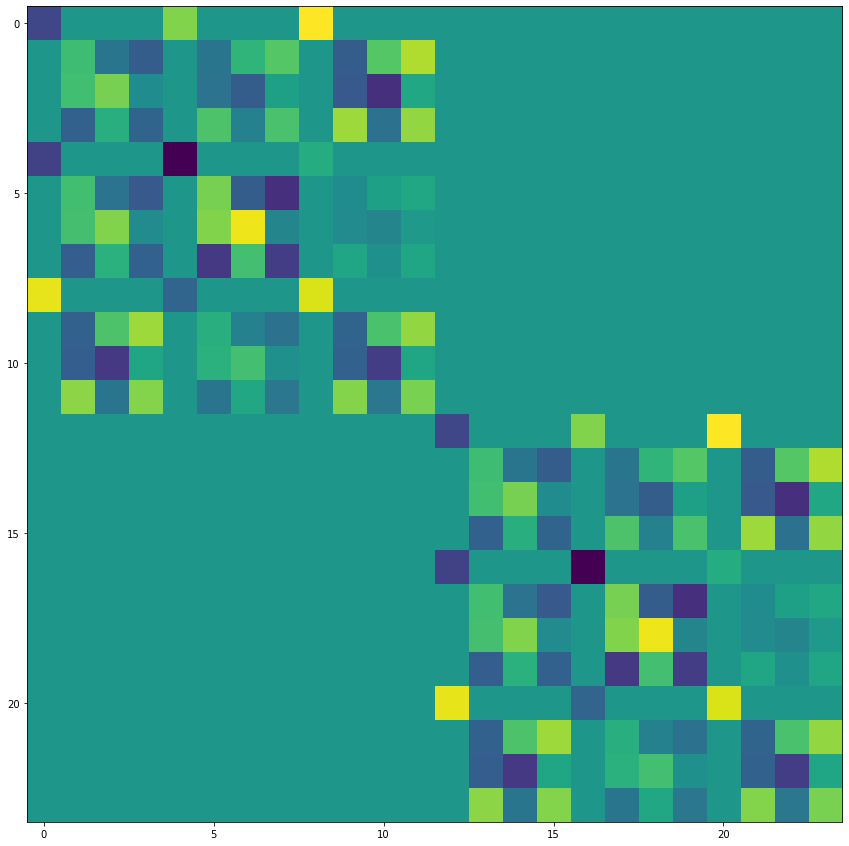

In [61]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(torch.kron(D_x, D_y));

Note that the representation of $R$ for $A$ shown above is now not an _irreducible_ representation. We can, however, transform it back into a direct sum of irreducible representations via a change-of-basis matrix (see the Clebsch-Gordan coefficients for more detail). Instead of doing this manually every time we want to compute a tensor product, such as the outer product we computed in $A$ above, we can use the ```FullTensorProduct``` from ```e3nn```, which takes care of this automatically:


In [62]:
tp = o3.FullTensorProduct(irreps_x, irreps_y)
print(tp)

FullTensorProduct(2x1o x 1x0e+1x1e -> 2x0o+4x1o+2x2o | 8 paths | 0 weights)


When we print it, the `FullTensorProduct` describes its two input irreps and its _output_ irreps, which have been transformed into a direct sum of irreps. 

Finally, we can compute the `FullTensorProduct`:When we print it, the `FullTensorProduct` describes its two input irreps and its _output_ irreps, which have been transformed into a direct sum of irreps. 


In [63]:
tp(x, y)

tensor([-1.0864, -3.1203,  0.2314,  0.5396,  0.4597, -0.3769,  0.4949,  0.0449,
        -1.0686,  4.0343, -4.1978, -1.7918, -1.1304, -2.5806,  2.2682,  3.2005,
        -1.2457, -3.0496, -3.3405,  1.7461,  4.2049,  0.3593, -1.9853,  2.4124])

We can also visualize the representation of $R$ for this output.  Note that the block diagonal structure of the visualization matches the output ```Irreps```: 


* $2 \times l=0$ scalars
* $4 \times l=1 $ vectors
* $2 \times l=2$ tensors


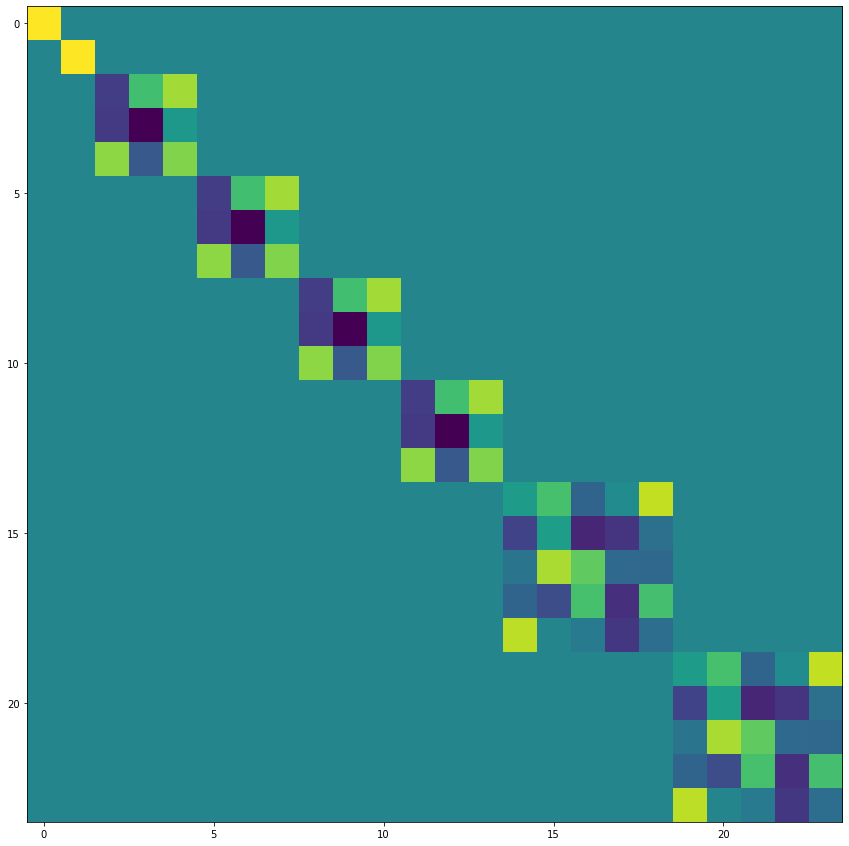

In [64]:

D = tp.irreps_out.D_from_matrix(R)
plt.figure(figsize=(15,15))
plt.imshow(D);


# NequIP

After learning about the ```Irreps``` and ```e3nn```, we are ready to ues NequIP. We will outline input to the code, how to build a network, how to load data, the interface to ```pytorch_geometric```, as well as training and predicting with a network. 

Let's start with a clean directory. 


In [65]:
!rm -rf ./results/
!rm -rf ./tutorial_data
!rm -rf ./tutorial-results

We use float32 as our default type. If you care about very high equivariance precision, set it to torch.float64.


In [66]:
import torch
torch.set_default_dtype(torch.float32)

## Input

Input to the code works easiest via a config file. This directory contains a tutorial.yaml file with an extensive set of inputs. You will not need all of these, but they cover most of what you might need at some point. Now might be a good time to take a quick look at that file. 


In [67]:
from nequip.utils import Config
config = Config.from_file('./tutorial.yaml')

Let's take a quick look at what is inside our config. Many of these are self-explanatory, such as batch size, but there are a few key parameters to be aware of. We will go through the most important ones here below.


In [68]:
import pprint
pprint.pprint(config.as_dict())

{'BesselBasis_trainable': True,
 'PolynomialCutoff_p': 6,
 'append': False,
 'avg_num_neighbors': None,
 'batch_size': 1,
 'chemical_embedding_irreps_out': '8x0e',
 'compile_model': False,
 'conv_to_output_hidden_irreps_out': '8x0e',
 'dataset': 'npz',
 'dataset_file_name': './tutorial_data/benzene_ccsd_t-train.npz',
 'dataset_url': 'http://quantum-machine.org/gdml/data/npz/benzene_ccsdt_t-train.zip',
 'default_dtype': 'float32',
 'ema_decay': 0.999,
 'ema_use_num_updates': True,
 'feature_irreps_hidden': '8x0o + 8x0e + 8x1o + 8x1e',
 'invariant_layers': 1,
 'invariant_neurons': 8,
 'irreps_edge_sh': '0e + 1o',
 'key_mapping': {'E': 'total_energy',
                 'F': 'forces',
                 'R': 'pos',
                 'z': 'atomic_numbers'},
 'learning_rate': 0.01,
 'log_batch_freq': 5,
 'log_epoch_freq': 1,
 'loss_coeffs': {'forces': 100, 'total_energy': 1},
 'lr_scheduler_factor': 0.5,
 'lr_scheduler_name': 'ReduceLROnPlateau',
 'lr_scheduler_patience': 100,
 'max_epochs': 25,

## Logging

Outputs in NequIP include a human-readable logfile, numpy-format logs, and saved model files for further use or restarting an interrupted training run. All of these outputs are stored in the directory specified by `$root/$project` in your config. (If the directory already exists, `$root/$project_$datetime` will be used). 


In [69]:
import logging




**Optional:** We use the tool [Weights&Biases](https://wandb.ai/) for model and metrics logging.
This is optional --- everything works fine without it as long as ```wandb: false ``` is set in your config file. 

We can now instantiate a Trainer object, which will take care of training as well as a series of callback functions for model saving, logging, early stopping, etc.: 


In [70]:
from nequip.train.trainer import Trainer
trainer = Trainer(model=None, **dict(config))

Torch device: cpu
* Initialization
BesselBasis_trainable: true
PolynomialCutoff_p: 6
append: false
avg_num_neighbors: &id001 !!python/name:builtins.NoneType ''
batch_size: 1
chemical_embedding_irreps_out: 8x0e
compile_model: false
conv_to_output_hidden_irreps_out: 8x0e
dataloader_num_workers: 0
dataset: npz
dataset_file_name: ./tutorial_data/benzene_ccsd_t-train.npz
dataset_url: http://quantum-machine.org/gdml/data/npz/benzene_ccsdt_t-train.zip
default_dtype: float32
early_stop_lower_threshold: *id001
ema_decay: 0.999
ema_use_num_updates: true
end_of_batch_callbacks: []
end_of_epoch_callbacks: []
end_of_train_callbacks: []
exclude_keys: []
feature_irreps_hidden: 8x0o + 8x0e + 8x1o + 8x1e
final_callbacks: []
init_callbacks: []
invariant_layers: 1
invariant_neurons: 8
irreps_edge_sh: 0e + 1o
key_mapping: &id002 !!python/name:builtins.dict ''
learning_rate: 0.01
log_batch_freq: 5
log_epoch_freq: 1
loss_coeffs: *id002
lr_scheduler_factor: 0.5
lr_scheduler_kwargs: *id001
lr_scheduler_name: 


## Dataloaders

Next, let's load some data. For this tutorial, we will use a data set of Benzene MD data. We will train on 10 configurations sampled from an AIMD trajectory at T=500K and computed at CCSD(T) accuracy. We have positions, chemical species, potential energies, and forces. 


In [71]:
!mv benzene*.xyz ./tutorial_data
!rm *.zip

!curl http://quantum-machine.org/gdml/data/npz/benzene_ccsd_t.zip -o outfile.zip
!unzip outfile.zip
!rm -rf __MACOSX outfile outfile.zip
!rm -rf ./tutorial_data
!mkdir tutorial_data
!mv benzene* tutorial_data
!curl http://quantum-machine.org/gdml/data/xyz/benzene_ccsd_t.zip -o ourfile.zip
!unzip outfile.zip
!curl http://quantum-machine.org/gdml/data/xyz/benzene_ccsd_t.zip -o outfile.zip
!unzip outfile.zip
!mv benzene*.xyz ./tutorial_data
!rm *.zip
!ls tutorial_data

mv: rename benzene*.xyz to ./tutorial_data: No such file or directory
rm: *.zip: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  823k  100  823k    0     0   200k      0  0:00:04  0:00:04 --:--:--  200k0:09 --:--:--  0:00:09 9224704  0:00:02  0:00:02  172k
Archive:  outfile.zip
  inflating: benzene_ccsd_t-train.npz  
   creating: __MACOSX/
  inflating: __MACOSX/._benzene_ccsd_t-train.npz  
  inflating: benzene_ccsd_t-test.npz  
  inflating: __MACOSX/._benzene_ccsd_t-test.npz  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  809k  100  809k    0     0  97789      0  0:00:08  0:00:08 --:--:--  102k0:00:01  0:00:08 9028991568      0  0:00:09  0:00:06  0:00:03 91963
unzip:  cannot find or open outfile.zip, outfile.zip.zip or outfile.zip.Z

Let's visualize what we just downloaded: 

In [72]:
from ase.io import read
atoms = read('./tutorial_data/benzene_ccsd_t-train.xyz', index=0)

from ase.visualize import view
view(atoms, viewer='x3d')

Let's actually load the dataset into the NequIP code. Note that the very first time you specify a data set, the code will pre-compute the neighborlists for all structures in the data set with the cutoff radius you specified. That might take a little bit, but will save you tons of time down the road: if you run the same data set with the same cutoff again, it will simply load the data. This makes training a lot faster. 


In [73]:
from nequip.utils import dataset_from_config
dataset = dataset_from_config(config)
logging.info(f"Successfully loaded the data set of type {dataset}...")

Processing...


Loaded data: Batch(batch=[12000], cell=[1000, 3, 3], edge_cell_shift=[113786, 3], edge_index=[2, 113786], forces=[12000, 3], pbc=[1000, 3], pos=[12000, 3], ptr=[1001], total_energy=[1000, 1])
Successfully loaded the data set of type NpzDataset(1000)...


Done!


Finally, we tell the `Trainer` about the dataset:

In [74]:
trainer.set_dataset(dataset)



## Normalization

Next, we normalize the targets we train to. We subtract the mean from the potential energies and scale both energies and forces by the standard deviation of the forces across all flattened force components. Note that you may never reduce the mean of the forces in a model that computes forces as the gradient of a potential energy as this will break equivariance. 


In [75]:
from nequip.data import AtomicDataDict

To do this, we use the `.statistics()` method of our `AtomicDataset`, which computes the statistics of specified fields across the dataset. It has three modes:
 - `"rms"` (root mean square) computes $\sqrt{\frac{1}{N}\sum_i{x_i^2}}$ where $x$ is the field in question
 - `"mean_std"` which calculates the mean and std of the variable
 - `"count"` which bincounts discrete variables like atomic number

In [76]:
(
    (forces_std,),
    (energies_mean, energies_std),
    (allowed_species, Z_count),
) = trainer.dataset_train.statistics(
    fields=[
        AtomicDataDict.FORCE_KEY,
        AtomicDataDict.TOTAL_ENERGY_KEY,
        AtomicDataDict.ATOMIC_NUMBERS_KEY,
    ],
    modes=["rms", "mean_std", "count"],
)

Note that we only compute the statistics from the training set, since the normalization constants can be considered to be part of the learned weights of the network. Also note the use of the standard keys defined in `AtomicDataDict`, such as `AtomicDataDict.TOTAL_ENERGY_KEY`. These are just strings defined as constants for convinience and to avoid typos. Most of the modules in NequIP use sane standard keys by default, but all can be configured to act on data fields with any key.


## Building a network to predict Energies and Forces

Finally we are ready to build a model. We will start by building a model for energies and conservative forces. This will consist of two steps:

1. First, we will build a model that predicts the potential energy, an invariant scalar, as a sum over learned atomic energies

2. In a second step, we compute the atomic forces as the negative gradient of our energy network, yielding energy-conserving and rotation-equivarint forces. 

We have built in functions to build typical networks for energy + forces which you can just import as shown below: 
(This is used in ```train.py```, for example.)


In [77]:
from nequip.models import ForceModel
config.update(dict(allowed_species=allowed_species))
force_model_ = ForceModel(**dict(config))

To show you how to build your own models, however, in this tutorial we will explicitly build our own networks. 

**Important**: Note that to simply use NequIP for energy/force prediction tasks, all you need to change is your config file and ```train.py```. Here we will cover the details in case you want to tweak the networks / design your own. 

We build the model using the class ```SequentialGraphNetwork```, a class that build a network through a ```Sequential``` of layers, all of which input and output a graph. The ```from_parameters``` method of this class takes two inputs: 

1. ```shared_params```, a dictionary containing the model parameters used in various parts of the code
2. ```layers```, a dictionary containing a set of layer types in the order in which they will be evaluated. 

Let's run through the layers of our typical energy predicting network. We start by embedding the nodes / chemical species as well as the edges, in our case embedding interatomic vector into spherical harmonics as well as embedding interatomic distance into a basis: 

* ```OneHotAtomicEncoding```: we start by embedding atomic numbers (e.g. 1/H and 6/C) into one-hot features
* ```SphericalHarmonicEdgeAttr```: the spherical harmonics embedding of interatomic vectors: $Y_l^m(\vec{r}_{ij})$
* ```RadialBasisEncoding```: a basis embedding of interatomic distances. We use the Bessel Basis together with a smooth cutoff function that ensures continuity at the cutoff (those are the defaults).
* ```AtomiwiseLinear``` for an initial chemcial embedding of each atom: ```AtomwiseLinear``` layers act independently but with shared weights on all atoms in the system, i.e. they do not communicate information between atoms. These are the equivariant equivalent of a Dense layer. We use this first layer to take us from the space of species one-hots (2 scalar in the case of Benzene, representing C and H) into the feature space, in our case specified by ```chemical_embedding_irreps_out': '8x0e'``` in the config file. 

After the embedding, we have the core of the network, the Convolution: 

* ```ConvNetLayer```: this is a series of convolution layers as described in the NequIP paper. It contains the most fundamental operations of the network, and consists of a) an AtomwiseLinear, b) the equivariant convolution, c) another AtomwiseLinear, and finally d) a nonlinearity (in our case based on a ```Gate```).

After a series of convolution / Message Passing, we want to go from the learned features to the atomic outputs. 

* first, we use another ```AtomwiseLinear```, this time named ```conv_to_output_hidden```. This takes us from the final even scalars of the convolution to an intermediate representation in the output block. This is simply an intermediate step to reduce the feature dimension, e.g. from 32 --> 8, in our case here, we also set this to ```8x0e```
* a final ```AtomwiseLinear```, this time labeled ```output_hidden_to_scalar```. This takes us from the feature representation to the single scalar output which we interpret as the atomic potential energy
* we also have an option to shift and/or scale atoms by species-dependent factor. For example, one might argue that a C atom and a H atom could benefit from different learnable offsets and scales to account for their different chemistries. This behavior is turned off by default as it is not needed in most cases, but might help in certain situation. 
* ```AtomwiseReduce```, a simple sum over atomic outputs, this gives us the total predicted potential energy, a sum over atomic potential energies. 


In [78]:
import logging

from nequip.data import AtomicDataDict
from nequip.nn import (
    GraphModuleMixin,
    SequentialGraphNetwork,
    AtomwiseLinear,
    AtomwiseReduce,
    ForceOutput,
    PerSpeciesScaleShift,
    ConvNetLayer,
)
from nequip.nn.embedding import (
    OneHotAtomEncoding,
    RadialBasisEdgeEncoding,
    SphericalHarmonicEdgeAttrs,
)

def EnergyModel(**shared_params) -> SequentialGraphNetwork:
    """Base default energy model archetecture.

    For minimal and full configuration option listings, see ``minimal.yaml`` and ``example.yaml``.
    """
    logging.debug("Start building the network model")

    num_layers = shared_params.pop("num_layers", 3)
    add_per_species_shift = shared_params.pop("PerSpeciesScaleShift_enable", False)

    layers = {
        # -- Encode --
        "one_hot": OneHotAtomEncoding,
        "spharm_edges": SphericalHarmonicEdgeAttrs,
        "radial_basis": RadialBasisEdgeEncoding,
        # -- Embed features --
        "chemical_embedding": AtomwiseLinear,
    }

    # add convnet layers
    # insertion preserves order
    for layer_i in range(num_layers):
        layers[f"layer{layer_i}_convnet"] = ConvNetLayer

    # .update also maintains insertion order
    layers.update(
        {
            # -- output block --
            "conv_to_output_hidden": AtomwiseLinear,
            "output_hidden_to_scalar": (
                AtomwiseLinear,
                dict(irreps_out="1x0e", out_field=AtomicDataDict.PER_ATOM_ENERGY_KEY),
            ),
        }
    )

    if add_per_species_shift:
        layers["per_species_scale_shift"] = (
            PerSpeciesScaleShift,
            dict(
                field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
                out_field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
            ),
        )

    layers["total_energy_sum"] = (
        AtomwiseReduce,
        dict(
            reduce="sum",
            field=AtomicDataDict.PER_ATOM_ENERGY_KEY,
            out_field=AtomicDataDict.TOTAL_ENERGY_KEY,
        ),
    )

    return SequentialGraphNetwork.from_parameters(
        shared_params=shared_params,
        layers=layers,
    )



We can now use the ```energy_model``` we just built to construct a ```ForceModel``` with the help of the ```ForceOutput``` module. This module will in turn call the ```GradientOutput``` class, a general class to compute arbitrary gradients. In our case, we want a gradient of ```energy_model``` with regards to the positions. We specify what we take the gradient of, the argument with respect to which we compute the gradient, and in this case also the sign as forces are the negative gradient of the potential energy.


In [79]:
def ForceModel(**shared_params) -> GraphModuleMixin:
    """Base default energy and force model archetecture.

    For minimal and full configuration option listings, see ``minimal.yaml`` and ``example.yaml``.

    A convinience method, equivalent to constructing ``EnergyModel`` and passing it to ``nequip.nn.ForceOutput``.
    """
    energy_model = EnergyModel(**shared_params)
    return ForceOutput(energy_model=energy_model)

Let's actually instantiate the objects: 

In [80]:
core_model = ForceModel(**dict(config))
logging.info("Successfully built the network...")

Successfully built the network...




Since we normalized the targets, the model will also learn in this normalized space. To go back to our actual space, we have to rescale the output. We do this using the ```RescaleOutput``` module which wraps a model -- in our case, our force model -- and rescales its outputs appropriately.


In [81]:

from nequip.nn import RescaleOutput

final_model = RescaleOutput(
    model=core_model, 
    scale_keys=[AtomicDataDict.TOTAL_ENERGY_KEY]
    + (
        [AtomicDataDict.FORCE_KEY]
        if AtomicDataDict.FORCE_KEY in core_model.irreps_out
        else []
    ),
    scale_by=forces_std,
    shift_keys=AtomicDataDict.TOTAL_ENERGY_KEY,
    shift_by=energies_mean, 
    trainable_global_rescale_shift=config.get(
        "trainable_global_rescale_shift", False
    ),
    trainable_global_rescale_scale=config.get(
        "trainable_global_rescale_scale", False
    ),
)

Finally, we associate the model with the ```Trainer``` object: 

In [82]:
trainer.model = final_model


## Training a network

We are now ready to actually train a model. The process will log a series of metrics. This is a very small toy network and a small training set of 25 configurations, and we'll only train for a few epochs to get a feeling for it.



In [83]:
trainer.train()

Number of weights: 4576
! Starting training ...

Training
# Epoch batch         loss       loss_f       loss_e       f_rmse        f_mae        e_mae
    1     5         87.2        0.865        0.685         19.2         12.9         17.1
    1    10           76        0.636         12.4         16.5         11.6         72.6
    1    15         65.7        0.613         4.41         16.2         11.4         43.4
    1    20           81        0.767         4.34         18.1         13.5           43
    1    25         31.2        0.277         3.45         10.9         7.91         38.3

Validation
# Epoch batch         loss       loss_f       loss_e       f_rmse        f_mae        e_mae
    1     5           44        0.404         3.53         13.1         10.9         38.8
    1    10         30.1         0.27         3.08         10.7         8.38         36.2


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        

    7     5         2.66       0.0262       0.0314         3.34         2.88         3.66
    7    10          2.2        0.021        0.103         2.99         2.23         6.64
    7    15         7.35       0.0732       0.0333         5.58         4.19         3.77
    7    20         6.29       0.0622       0.0664         5.15         3.21         5.33
    7    25         7.93       0.0752        0.406         5.66         4.43         13.2

Validation
# Epoch batch         loss       loss_f       loss_e       f_rmse        f_mae        e_mae
    7     5         4.65       0.0437        0.278         4.32         3.24         10.9
    7    10         4.03       0.0379        0.235         4.02         3.08           10


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Train               7   11.507     0.01       0.0531       0.0997         5.41         4.76         3.54         5.51
  Validation #    Epoch 

   13    15         7.12         0.07         0.12         5.46         4.02         7.16
   13    20         4.37       0.0433        0.032          4.3         3.35          3.7
   13    25         2.72       0.0272      0.00407          3.4         2.84         1.31

Validation
# Epoch batch         loss       loss_f       loss_e       f_rmse        f_mae        e_mae
   13     5            4         0.04     0.000112         4.13         3.38        0.219
   13    10         2.23       0.0223      0.00485         3.08         2.51         1.44


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Train              13   27.448     0.01       0.0391        0.066         3.98         4.08         3.13         4.47
  Validation #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Validation         13   27.448     0.01       0.0275      0.00583         2.75    


Validation
# Epoch batch         loss       loss_f       loss_e       f_rmse        f_mae        e_mae
   19     5         2.43        0.024       0.0275          3.2         2.59         3.42
   19    10         1.35       0.0135      0.00464          2.4         1.93         1.41


  Train      #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Train              19   39.230     0.01       0.0194       0.0418         1.98         2.87         2.18         3.52
  Validation #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Validation         19   39.230     0.01       0.0172       0.0107         1.73         2.71            2            2
! Best model       19    1.730

Training
# Epoch batch         loss       loss_f       loss_e       f_rmse        f_mae        e_mae
   20     5         1.34       0.0132       0.0223         2.37         2.02         3.08
   20    10



  Train      #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Train              25   50.570     0.01       0.0187       0.0323          1.9         2.82         2.18         3.01
  Validation #    Epoch      wal       LR       loss_f       loss_e         loss       f_rmse        f_mae        e_mae
! Validation         25   50.570     0.01       0.0146      0.00676         1.47          2.5         1.86         1.59
! Best model       25    1.470
! Stop training for eaching max epochs
Wall time: 50.70238917900008




## Inference

Next, let's predict with our newly trained potential. We will need positions and chemical species. First, let's load the numpy data. 


In [84]:
import numpy as np

benzene_data = np.load(config.dataset_file_name)

r = benzene_data['R'][-1]
forces = benzene_data['F'][-1]

To be able to pass numpy-loaded data to the network, we need to transfrom the input into something that PyTorch Geometric and NequIP can understand. The easiest way to do this is via the ``` AtomicData``` object, a neighbor graph that inherits from PyTorch-Geometric's ``` Data```  object and the ```from_points()``` method that transforms numpy/pytorch inputs into ```AtomicData``` graph suitable for NequIP.


In [85]:
from nequip.data import AtomicData

data = AtomicData.from_points(
    pos=r,
    r_max=config['r_max'], 
    **{AtomicDataDict.ATOMIC_NUMBERS_KEY: torch.Tensor(torch.from_numpy(benzene_data['z'].astype(np.float32))).to(torch.int64)}
)

We will also convert tWe will also convert the atomic number to PyTorchhe atomic number to PyTorch

In [86]:
atomic_numbers = torch.Tensor(torch.from_numpy(benzene_data['z'].astype(np.float32))).to(torch.int64)


Finally, let's predict and visualize. Even though we only trained a tiny 3-layer network with l-max=1 for 25 epochs on an extremely small data set, we already see very good results! :)

First, we convert the ```AtomicData``` object to an ```AtomicDataDict``` which forms the fundamental input to the network: 


In [87]:
pred = core_model(AtomicData.to_AtomicDataDict(data))['forces']



Side-note: `AtomicData` is a full-fledged `torch_geometric.data.Data` object that can be used with `torch_geometric` tools. `AtomicDataDict` is a much simpler dictionary mapping string keys to `torch.Tensor`s that we use to ensure that our models are TorchScript compatible.

We can plot our predicted forces:

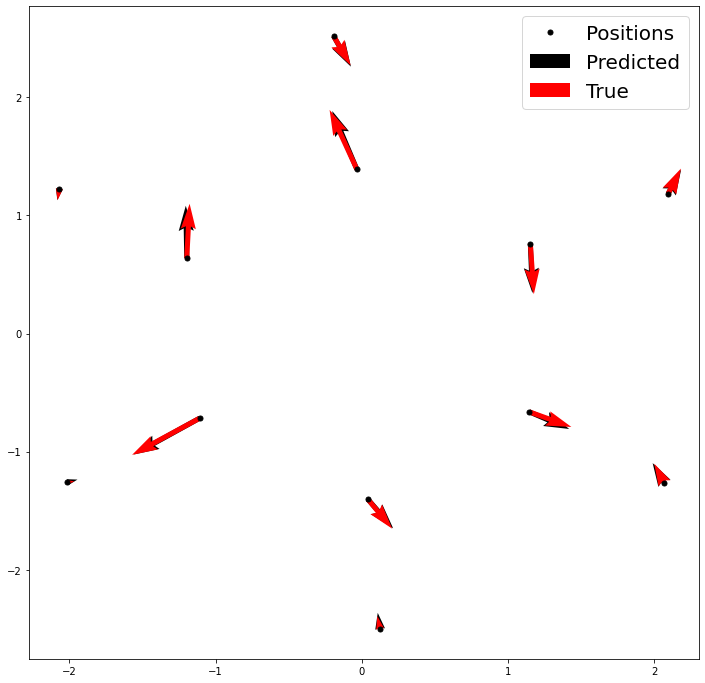

In [88]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 12))

plt.plot(
    r[:, 0],
    r[:, 1],
    '.k',
    markersize=10,
)

plt.quiver(
    r[:, 0],
    r[:, 1],
    pred[:, 0].detach().numpy(), 
    pred[:, 1].detach().numpy()
)

plt.quiver(
    r[:, 0], 
    r[:, 1], 
    forces[:, 0], 
    forces[:, 1],
    color='red'
)

plt.legend(['Positions', 'Predicted', 'True'], prop={'size': 20})
plt.show()


This concludes our tutorial!

If you have questions, please don't hesitate to reach out at batzner@g.harvard.edu